## Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [4]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [5]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold

In [6]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score

In [7]:
from imblearn.over_sampling import SMOTE

## Load Data

In [8]:
X_train = pd.read_csv("../data/final/X_train_split.csv")
X_test = pd.read_csv("../data/final/X_test_split.csv")
y_train = pd.read_csv("../data/final/y_train_split.csv")
y_test = pd.read_csv("../data/final/y_test_split.csv")

In [9]:
train_pre = pd.read_csv("../data/final/train_preprocessed.csv")
test_pre = pd.read_csv("../data/final/test_preprocessed.csv")

## Model Selection

### Baseline Models: KNN, Decision Tree Classifier and Logistic Regression

In [10]:
knn_base = KNeighborsClassifier()
tree_base = DecisionTreeClassifier(random_state = 19)
logreg_base = LogisticRegression(max_iter = 500, random_state = 19)
base_models = [knn_base, tree_base, logreg_base]

In [11]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

for model in base_models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{model} Classification Report and Confusion Matrix")
    print("-" * 75)
    print(classification_report(y_test, y_pred, zero_division=0))
    print(confusion_matrix(y_test, y_pred))
    print("\n")

KNeighborsClassifier() Classification Report and Confusion Matrix
---------------------------------------------------------------------------
              precision    recall  f1-score   support

       False       0.94      1.00      0.97     13711
        True       0.15      0.01      0.02       937

    accuracy                           0.93     14648
   macro avg       0.54      0.50      0.49     14648
weighted avg       0.89      0.93      0.90     14648

[[13666    45]
 [  929     8]]


DecisionTreeClassifier(random_state=19) Classification Report and Confusion Matrix
---------------------------------------------------------------------------
              precision    recall  f1-score   support

       False       0.94      0.92      0.93     13711
        True       0.07      0.09      0.08       937

    accuracy                           0.87     14648
   macro avg       0.50      0.51      0.50     14648
weighted avg       0.88      0.87      0.88     14648

[[12680  103

### Random Forest Classifier

#### Base RFC

In [12]:
rf_clf = RandomForestClassifier(random_state = 19)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

       False       0.94      0.99      0.96     13711
        True       0.06      0.01      0.01       937

    accuracy                           0.93     14648
   macro avg       0.50      0.50      0.49     14648
weighted avg       0.88      0.93      0.90     14648



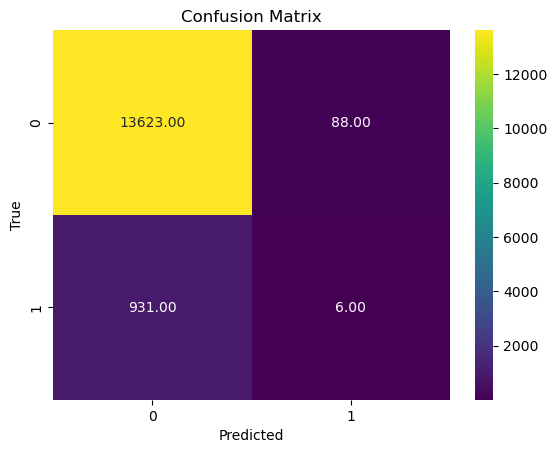

In [13]:
print("Classification Report")
print("-" * 55)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot= True, fmt=".2f", cmap="viridis")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

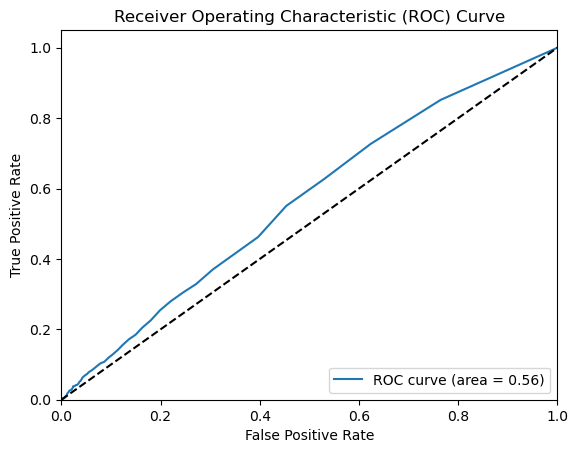

In [14]:
y_pred_proba = rf_clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#### Hyperparameter Tuning for RFC

In [15]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced', {0: 1, 1: 10}]
}

rf_clf_search = RandomForestClassifier(random_state = 19)
random_search = RandomizedSearchCV(rf_clf_search, param_grid, cv = 5, scoring = "f1")
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=19),
                   param_distributions={'class_weight': ['balanced',
                                                         {0: 1, 1: 10}],
                                        'max_depth': [None, 10, 20],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [100, 200]},
                   scoring='f1')

In [16]:
best_rf_clf = random_search.best_estimator_
y_pred = best_rf_clf.predict(X_test)
print(random_search.best_params_)
print(classification_report(y_test, y_pred))

{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'class_weight': 'balanced'}
              precision    recall  f1-score   support

       False       0.94      0.93      0.93     13711
        True       0.09      0.10      0.09       937

    accuracy                           0.88     14648
   macro avg       0.51      0.52      0.51     14648
weighted avg       0.88      0.88      0.88     14648



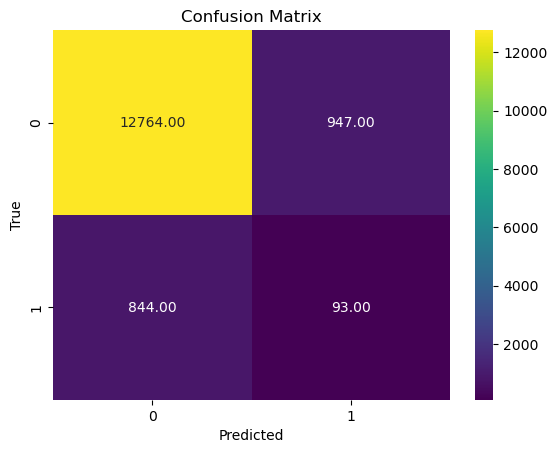

In [17]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot= True, fmt=".2f", cmap="viridis")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

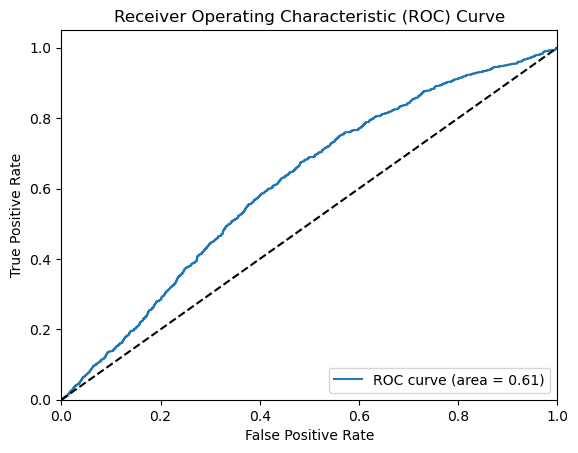

In [18]:
y_pred_proba = best_rf_clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Extreme Gradient Boosting

#### Base XGB

In [19]:
imbal_ratio = round(13711 / 937, 0)
xgb_clf = xgb.XGBClassifier(scale_pos_weight = imbal_ratio, random_state = 19)
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)

In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.95      0.71      0.81     13711
        True       0.09      0.42      0.15       937

    accuracy                           0.69     14648
   macro avg       0.52      0.57      0.48     14648
weighted avg       0.89      0.69      0.77     14648



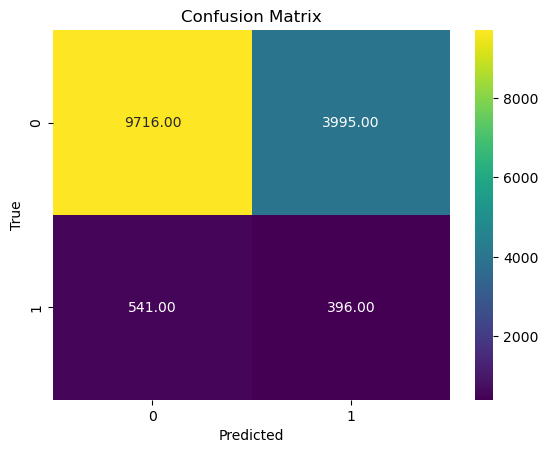

In [21]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot= True, fmt=".2f", cmap="viridis")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

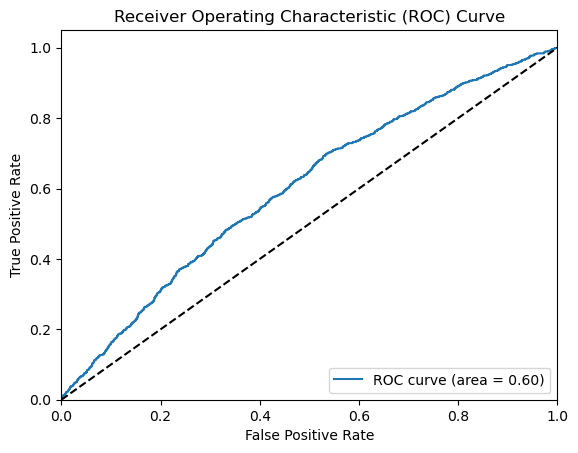

In [22]:
y_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#### Hyperparameter Tuning of XGB

In [23]:
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5]
}

xgb_clf_search = xgb.XGBClassifier(random_state = 19, scale_pos_weight = imbal_ratio)
random_search_xgb = RandomizedSearchCV(xgb_clf_search, param_dist, cv = 5, scoring = "f1")
random_search_xgb.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=19, ...),
                   param_distributions={'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.15,
                                                          0.2],
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   scoring='f1')

In [24]:
best_xgb_clf = random_search_xgb.best_estimator_
y_pred = best_xgb_clf.predict(X_test)
print(random_search_xgb.best_params_)
print(classification_report(y_test, y_pred))

{'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 0}
              precision    recall  f1-score   support

       False       0.96      0.55      0.70     13711
        True       0.09      0.69      0.17       937

    accuracy                           0.56     14648
   macro avg       0.53      0.62      0.43     14648
weighted avg       0.91      0.56      0.66     14648



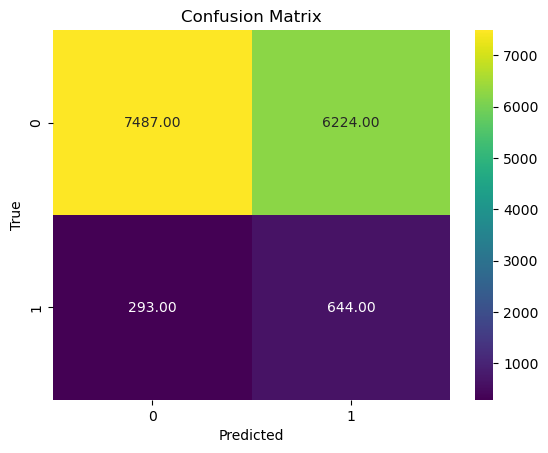

In [25]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot= True, fmt=".2f", cmap="viridis")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

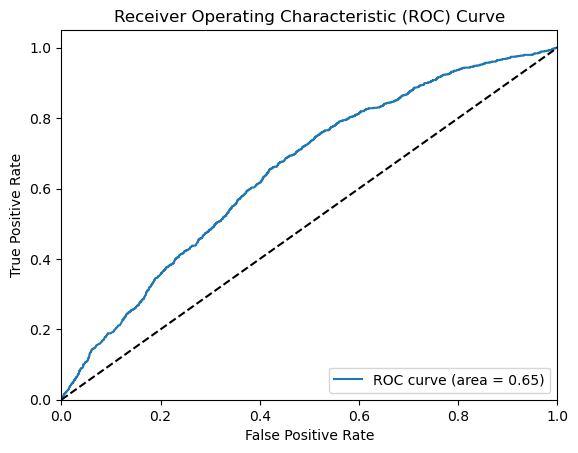

In [26]:
y_pred_proba = best_xgb_clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Dealing with Class Inbalance with SMOTE

### Synthetic Minority Over-sampling Technique (SMOTE)

In [27]:
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [28]:
xgb_smote = xgb.XGBClassifier(scale_pos_weight = imbal_ratio, random_state = 19)
xgb_smote.fit(X_resampled, y_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=19, ...)

In [29]:
y_pred_proba = xgb_smote.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
optimal_threshold = thresholds[np.argmax(recall - (1 - precision))]
y_pred_adjusted = (y_pred_proba >= optimal_threshold).astype(int)

In [30]:
print(classification_report(y_test, y_pred_adjusted))

              precision    recall  f1-score   support

       False       1.00      0.00      0.01     13711
        True       0.06      1.00      0.12       937

    accuracy                           0.07     14648
   macro avg       0.53      0.50      0.06     14648
weighted avg       0.94      0.07      0.01     14648



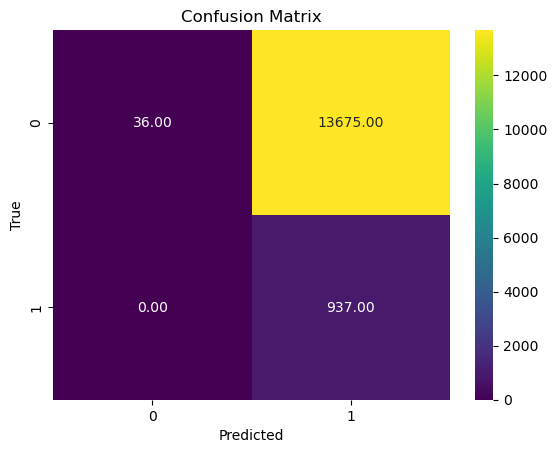

In [31]:
cm = confusion_matrix(y_test, y_pred_adjusted)
sns.heatmap(cm, annot= True, fmt=".2f", cmap="viridis")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

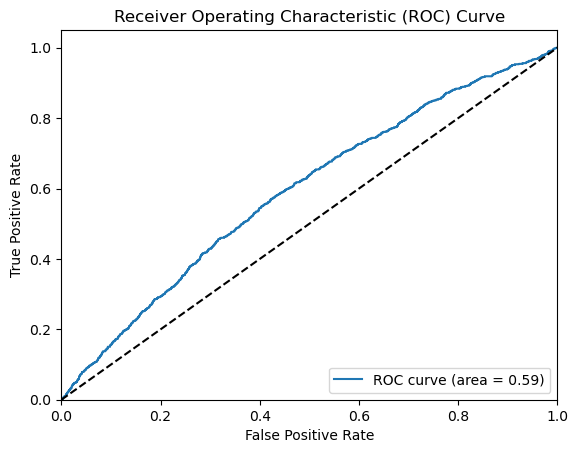

In [32]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Randomized Search XGB SMOTE

In [33]:
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5]
}

xgb_clf_inbal_search = xgb.XGBClassifier(random_state = 19, scale_pos_weight = imbal_ratio)
random_search_xgb_inbal = RandomizedSearchCV(xgb_clf_inbal_search, param_dist, cv = 5, scoring = "f1")
random_search_xgb_inbal.fit(X_resampled, y_resampled)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=19, ...),
                   param_distributions={'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.15,
                                                          0.2],
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   scoring='f1')

#### Optimal threshold based on Precision Recall Curve

In [34]:
best_xgb_inbal = random_search_xgb_inbal.best_estimator_
y_pred_proba = best_xgb_inbal.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
optimal_threshold = thresholds[np.argmax(recall - (1 - precision))]
y_pred_adjusted = (y_pred_proba >= optimal_threshold).astype(int)

In [35]:
print(classification_report(y_test, y_pred_adjusted, zero_division = 0))

              precision    recall  f1-score   support

       False       1.00      0.00      0.00     13711
        True       0.06      1.00      0.12       937

    accuracy                           0.07     14648
   macro avg       0.53      0.50      0.06     14648
weighted avg       0.94      0.07      0.01     14648



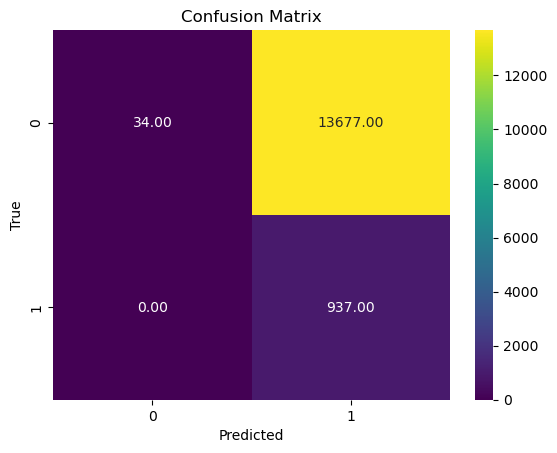

In [36]:
cm = confusion_matrix(y_test, y_pred_adjusted)
sns.heatmap(cm, annot= True, fmt=".2f", cmap="viridis")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

#### Optimal threshold based on ROC curve

In [37]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
y_pred_adjusted = (y_pred_proba >= optimal_threshold).astype(int)

In [38]:
print(classification_report(y_test, y_pred_adjusted))

              precision    recall  f1-score   support

       False       0.95      0.42      0.58     13711
        True       0.08      0.71      0.14       937

    accuracy                           0.44     14648
   macro avg       0.52      0.56      0.36     14648
weighted avg       0.90      0.44      0.55     14648



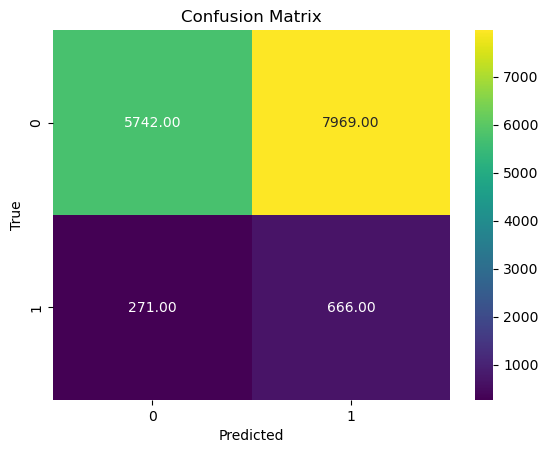

In [39]:
cm = confusion_matrix(y_test, y_pred_adjusted)
sns.heatmap(cm, annot= True, fmt=".2f", cmap="viridis")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

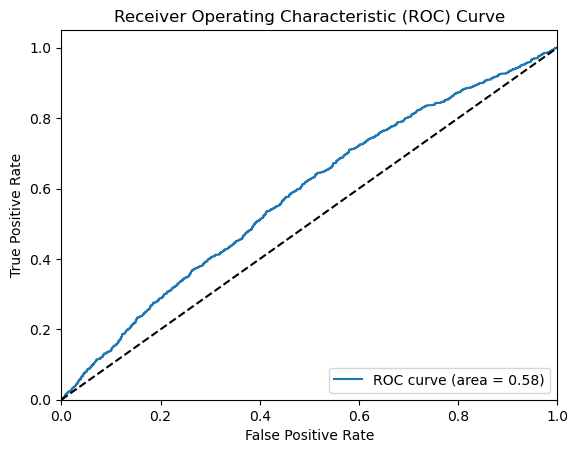

In [40]:
auc_score = roc_auc_score(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Neural Network: Multilayer Perceptron Classifier

In [41]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes = (100,), max_iter = 500, alpha = 0.0001, solver = 'adam', random_state = 19)

mlp.fit(X_resampled, y_resampled)

y_pred = mlp.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.95      0.74      0.83     13711
        True       0.09      0.37      0.14       937

    accuracy                           0.72     14648
   macro avg       0.52      0.56      0.49     14648
weighted avg       0.89      0.72      0.79     14648



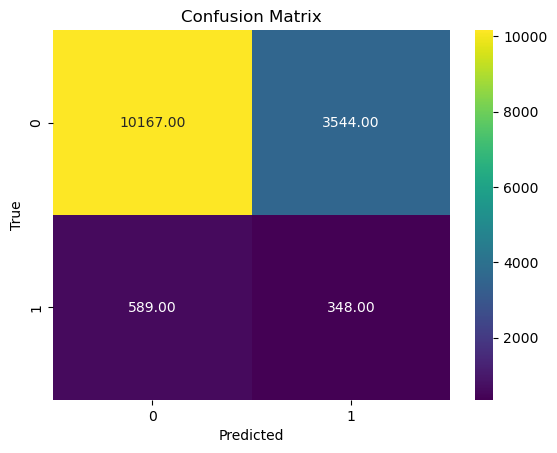

In [42]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot= True, fmt=".2f", cmap="viridis")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

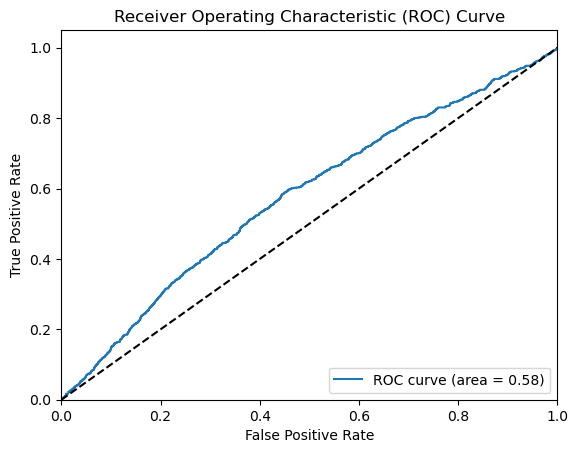

In [43]:
y_pred_proba = mlp.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Business Model Selection

### Business Cost Function

For this project and business case, the cost function is defined by:

C = (CFP * FP) + (CFN * FN)

Where:   
- CFP: The cost of a false positive
- CFN: The cost of a false negative
- FP: The number of false positives
- FN: The number of false negatives

In [44]:
def business_cost(cfp, cfn, fp, fn):
    C = (cfp * fp + cfn * fn)
    return C

### FP and FN of the developed models

In [49]:
base_knn = {"fp": 45, "fn": 929}
base_tree = {"fp": 1031, "fn": 856}
base_logreg = {"fp": 0, "fn": 937}

base_rfc = {"fp": 88, "fn": 931}
rfc_random_search = {"fp": 947, "fn": 844}

base_xgb = {"fp": 3995, "fn": 541}
xgb_random_search = {"fp": 6224, "fn": 293}

xgb_smote = {"fp": 13675, "fn": 0}
xgb_smote_random_search1 = {"fp": 13677, "fn": 0}
xgb_smote_random_search2 = {"fp": 7969, "fn": 271}

mlp = {"fp": 3544, "fn": 589}

In the context of Insurance Claims, CFN costs are typically several times higher than CFP costs. Therefore, we will explore different ratios between these costs, ranging from 5 to 50.  

In [50]:
cfp = 1
cfn_list = [5, 10, 20, 50]

results = []
for cfn in cfn_list:
    base_costs = {
        "knn": business_cost(cfp, cfn, base_knn["fp"], base_knn["fn"]),
        "tree": business_cost(cfp, cfn, base_tree["fp"], base_tree["fn"]),
        "logreg": business_cost(cfp, cfn, base_logreg["fp"], base_logreg["fn"]),
        "rfc": business_cost(cfp, cfn, base_rfc["fp"], base_rfc["fn"]),
        "rfc_random_search": business_cost(cfp, cfn, rfc_random_search["fp"], rfc_random_search["fn"]),
        "xgb": business_cost(cfp, cfn, base_xgb["fp"], base_xgb["fn"]),
        "xgb_random_search": business_cost(cfp, cfn, xgb_random_search["fp"], xgb_random_search["fn"]),
        "xgb_smote": business_cost(cfp, cfn, xgb_smote["fp"], xgb_smote["fn"]),
        "xgb_smote_random_search1": business_cost(cfp, cfn, xgb_smote_random_search1["fp"], xgb_smote_random_search1["fn"]),
        "xgb_smote_random_search2": business_cost(cfp, cfn, xgb_smote_random_search2["fp"], xgb_smote_random_search2["fn"]),
        "mlp": business_cost(cfp, cfn, mlp["fp"], mlp["fn"]),
    }
    results.append({
        "cfn": cfn,
        **base_costs
    })

In [51]:
df = pd.DataFrame(results)
df.set_index("cfn", inplace=True)

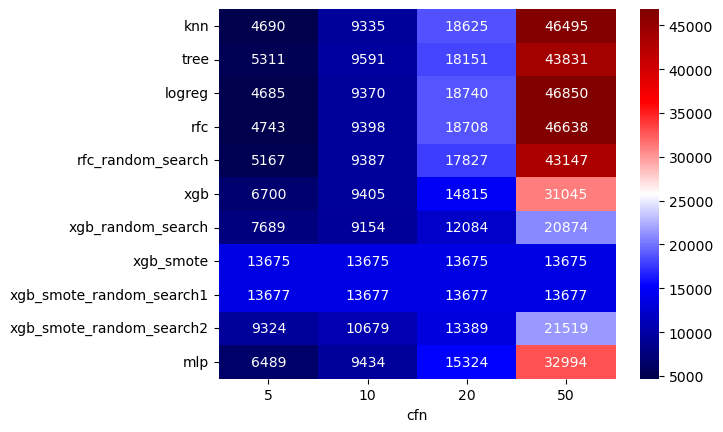

In [52]:
sns.heatmap(df.T, annot = True, fmt=".0f", cmap = "seismic")
plt.show()

When the CFN is 5 times the CFP, the best models are: 1 Base Logistic Regression, 2 Base KNN, 3 Base Random Forest Classifier.  
When the CFN is 10 times the CFP, the best models are: 1 XGB (Random Search), 2 Base KNN, 3 Base Logistic Regression.  
When the CFN is 20 times the CFP, the best models are: 1 XGB (Random Search), 2 XGB (SMOTE + Random Search2), 3 XGB (SMOTE).  
When the CFN is 50 times the CFP, the best models are: 1 XGB (SMOTE), 2 XGB (SMOTE + Random Search1), 3 XGB (Random Search). 

### FInal Model Selection

The most probable scenarios occur with CFN values between 10 and 20.  
Since the XGB (Random Search) is the model that perform best, in the most probable scenarios, it is the final selected model.  
This model exhibit strong performance with the highest Area Under the Curve (AUC) of the ROC, demonstrating robustness across various decision thresholds:  
- XGB (Random Search) AUC = 0.65  

The hyperparameters found by the Random Search are: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 0}  

The final selected model is XGB (Random Search). It demonstrated superior performance across multiple evaluation metrics, including the highest Area Under the Curve (AUC) of the ROC, robustness against different decision thresholds, and effective minimization of the targeted cost function.  